Train models that have different dimensionality, infer embeddings, and then calculate test metrics. 

In [11]:
import sys
import multiprocessing
import os
import pickle
import random

import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import model_selection
from scipy import stats
from sklearn import metrics

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/gpmodel-master")

from gpmodel import gpmodel 
from gpmodel import gpkernel
from gpmodel import gptools

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/src")
    
from embeddings_reproduction import embedding_tools

In [12]:
%matplotlib inline

In [13]:
sns.set_style('white')
sns.set_context('paper')

In [14]:
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 20})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'axes.labelsize': 25})
plt.rcParams.update({'legend.fontsize': 20})
plt.rcParams.update({'axes.titlesize': 25})

plt.rcParams.update({'axes.grid': False})

In [15]:
# assert gensim.__version__ == '1.0.1'
# assert np.__version__ == '1.13.1'
# assert pd.__version__ == '0.20.3'

In [16]:
sequence_dict = {}
sequence_dict['small'] = pd.read_csv('../inputs/small_uniprot.txt')
sequence_dict['original'] = pd.read_csv('../inputs/original.txt', comment='#')
#sequence_dict['scrambled'] = pd.read_csv('../inputs/r1.txt')
#sequence_dict['random'] = pd.read_csv('../inputs/r2.txt')
#sequence_dict['uniform'] = pd.read_csv('../inputs/r3.txt')

In [17]:
tasks = ['cut_secreted']
hypers = [('original', 4, 3)]
dims = (4, 8, 16, 32, 96)#, 128)

In [18]:
def train(X, k, window, dim):
    name_list = [X, str(k), str(window), str(dim)]
    print('X\t\tk\twindow\tdim')
    print(name_list[0] + '\t' + '\t'.join(name_list[1:]))
    if os.path.isfile('../outputs/augmented_models/' + '_'.join(name_list) + '.pkl'):
        return
    kmer_hypers = {'k':k, 
                   'overlap':False,
                   'merge':False}
    model_hypers = {'vector_size': dim,
                    'min_count': 0,
                    'epochs': 25,
                    'window':window,
                    'workers': 2}
    documents = embedding_tools.Corpus(sequence_dict[X], kmer_hypers)
    model = Doc2Vec(**model_hypers)
    model.build_vocab(documents)
    %time model.train(documents,total_examples = 1000, epochs=25)
    model.save('../outputs/augmented_models/' + '_'.join(name_list) + '.pkl')

In [19]:
for X, k, w in hypers:
    for dim in dims:
        train(X, k, w, dim)

X		k	window	dim
original	4	3	4
X		k	window	dim
original	4	3	8
X		k	window	dim
original	4	3	16
X		k	window	dim
original	4	3	32
X		k	window	dim
original	4	3	96


In [20]:
models = os.listdir('../outputs/augmented_models/')
models = [m for m in models if m[-3:] == 'pkl']
models[0]

'small_4_3_8.pkl'

In [21]:
dfs = {}
dfs['cut_secreted'] = pd.read_csv('../inputs/cut_align_sp_secretion.txt')
#dfs['cut_secreted'] = pd.read_csv('../inputs/sp_secretion.txt')


dirs = {}
dirs['cut_secreted'] = '../outputs/cut_align_sp_secretion_d_embeddings/'
#dirs['cut_secreted'] = '../outputs/sp_secretion_d_embeddings/'


In [22]:
def infer_vectors(df, model, k, dest, overlap=False, method=None):       
    seqs = embedding_tools.get_seqs(df)
    if method is not None:
        seqs = embedding_tools.randomize_seqs(seqs, method=method)
    embeds = embedding_tools.get_embeddings_new(model, seqs, k=k,
                                                overlap=overlap)
    embeds = pd.DataFrame(embeds, index=df.name)
    terms = list(range(embeds.shape[1]))
    name = model.split('/')[-1]
    with open(dest + 'X_' + name, 'wb') as f:
        pickle.dump((embeds, terms), f)
        
for i, t in enumerate(tasks):
    #print(t)
    #print(i)
    Xs = os.listdir(dirs[t])

    name = '_'.join([str(h) for h in hypers[0]])
    print(name)
    for model in models:
        if name not in model:
            continue
        if 'X_' + model in Xs:
            continue
        print('Model ' + model + ' for dataset ' + t + ':')
        k = int(model.split('_')[1])
        print('Inferring...')
        #a = %pwd
        #print(a)
        %time infer_vectors(dfs[t], '../outputs/augmented_models/' + model, k, dirs[t])
        print('Success!')

original_4_3
Model original_4_3_16.pkl for dataset cut_secreted:
Inferring...


/home/apps/software/Python/3.6.1-IGB-gcc-4.9.4/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 11.4 s, sys: 172 ms, total: 11.5 s
Wall time: 13.2 s
Success!
Model original_4_3_4.pkl for dataset cut_secreted:
Inferring...


/home/apps/software/Python/3.6.1-IGB-gcc-4.9.4/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 10 s, sys: 140 ms, total: 10.2 s
Wall time: 10.8 s
Success!
Model original_4_3_96.pkl for dataset cut_secreted:
Inferring...


/home/apps/software/Python/3.6.1-IGB-gcc-4.9.4/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 12 s, sys: 712 ms, total: 12.7 s
Wall time: 21 s
Success!
Model original_4_3_32.pkl for dataset cut_secreted:
Inferring...


/home/apps/software/Python/3.6.1-IGB-gcc-4.9.4/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 10.5 s, sys: 298 ms, total: 10.8 s
Wall time: 14 s
Success!
Model original_4_3_8.pkl for dataset cut_secreted:
Inferring...


/home/apps/software/Python/3.6.1-IGB-gcc-4.9.4/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 10.3 s, sys: 110 ms, total: 10.4 s
Wall time: 11.3 s
Success!
Model original_4_3_128.pkl for dataset cut_secreted:
Inferring...


/home/apps/software/Python/3.6.1-IGB-gcc-4.9.4/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 13.8 s, sys: 1.09 s, total: 14.9 s
Wall time: 25.2 s
Success!


In [23]:
def select_X_and_Y(df, all_X, y_column):
    not_dropped = ~pd.isnull(df[y_column])
    not_dropped = pd.Series(not_dropped, index=df.index)
    Ys = df[not_dropped][y_column]
    Ys.index = df[not_dropped]['name']
    Xs = all_X.loc[Ys.index]
    return Xs, Ys

def score(Y, pred_Y, pred_var):
    r1 = stats.rankdata(Y)
    r2 = stats.rankdata(pred_Y)
    scores = {}
    scores['kendalltau'] = stats.kendalltau(r1, r2).correlation
    scores['R2'] = metrics.r2_score(Y, pred_Y)
    scores['mae'] = metrics.mean_absolute_error(Y, pred_Y)
    scores['SE'] = metrics.mean_squared_error(Y, pred_Y)
    scores['R'] = np.corrcoef(Y, pred_Y)[0, 1]
    log_ps = -0.5 * np.log(pred_var) - (pred_Y - Y)**2 / 2 / pred_var
    log_ps -= 0.5 * np.log(2 * np.pi)
    scores['log_loss'] = -np.sum(log_ps)
    return scores

def evaluate(df_train, df_test, X, task, X_name, guesses=None, kernel='matern'):
    X_train, y_train = select_X_and_Y(df_train, X, task)
    X_test, y_test = select_X_and_Y(df_test, X, task)
    n_train, d = X_train.shape
    n_test, d = X_test.shape
    if kernel == 'matern':
        k = gpkernel.MaternKernel('5/2')
    if kernel == 'cubic':
        k = gpkernel.PolynomialKernel(3)
    clf = gpmodel.GPRegressor(k, guesses=guesses)
    clf.fit(X_train, y_train)
    print(X_name)
    print(clf.hypers)
    mu, var = clf.predict(X_test)
    met1 = score(y_test, mu, np.diag(var))
    met1['task'] = task
    met1['X'] = X_name
    met1['d'] = int((X_name.split('.')[0]).split('_')[-1])
    met1['n_train'] = n_train
    met1['n_test'] = n_test
    met1['kernel'] = kernel
    met1 = pd.DataFrame(met1, index=[0])
    return met1, mu

In [24]:
fname = '../outputs/vary_d_test_4_3_cut_align.txt'
res = pd.DataFrame(index=[])

for t in tasks:
    df = dfs[t]
    e_dir = dirs[t]
    df_test = df[~df.is_train]
    df_train = df[df.is_train]

    # Embedding
    Xs = os.listdir(e_dir)
    for emb in Xs:
        with open(e_dir + emb, 'rb')  as f:
            X = pickle.load(f)
        if len(X) == 2:
            X = X[0]
        evals, mu = evaluate(df_train, df_test, X, t, emb[:-4], guesses=(0.1, 10))
        res = pd.concat((res, evals), ignore_index=True)
res.head()

X_original_4_3_128
[1.00806061 9.99994522]
X_original_4_3_8
[  1.0086187  280.54217439]
X_original_4_3_4
[  1.00854905 293.72142831]
X_original_4_3_16
[0.97823911 3.24365984]
X_original_4_3_96
[1.00770176 9.99980925]
X_original_4_3_32
[0.93323025 1.48587969]


,kendalltau,R2,mae,SE,R,log_loss,task,X,d,n_train,n_test,kernel
0,-0.080696,-0.007709,0.895709,0.990135,-0.131585,1346.455375,cut_secreted,X_original_4_3_128,128,117,31,matern
1,0.053798,-0.007498,0.895495,0.989927,0.180884,1439.955840,cut_secreted,X_original_4_3_8,8,117,31,matern
2,0.170359,-0.007501,0.895497,0.989930,0.133920,1439.596555,cut_secreted,X_original_4_3_4,4,117,31,matern
3,0.197258,0.046959,0.870080,0.936420,0.421590,330.150554,cut_secreted,X_original_4_3_16,16,117,31,matern
4,-0.031382,-0.007619,0.895743,0.990046,-0.037323,1312.166835,cut_secreted,X_original_4_3_96,96,117,31,matern


In [25]:
res.to_csv(fname, index=False)

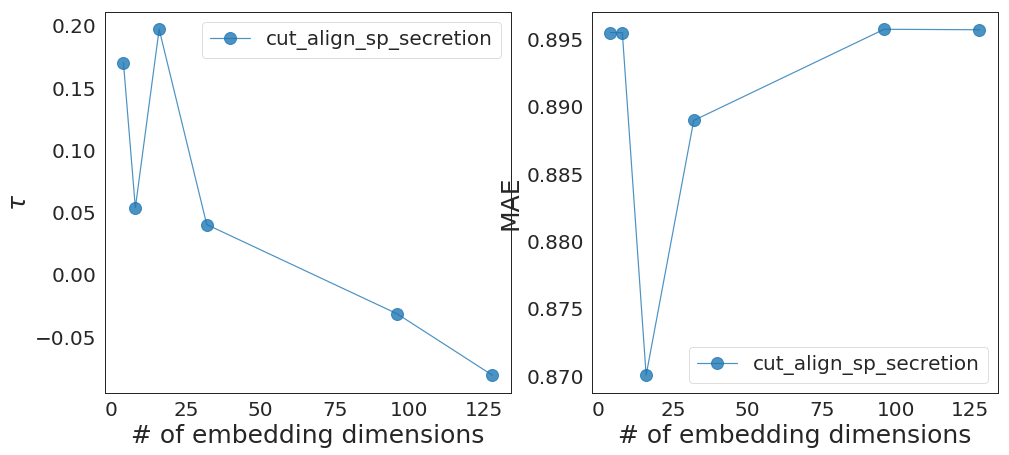

In [27]:
labels = ['cut_align_sp_secretion']
markers = ['-o']

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

for t, la, ma in zip(tasks, labels, markers):
    df_lim = res[res['task'] == t]
    df_lim = df_lim.sort_values('d')
    for i, metric in enumerate(['kendalltau', 'mae']):
        _ = axs[i].plot(df_lim['d'], df_lim[metric], ma, label=la, alpha=0.8, ms=12)
        _ = axs[i].legend()
        _ = axs[i].set_xlabel('# of embedding dimensions')

_ = axs[0].set_ylabel(r'$\tau$')
_ = axs[1].set_ylabel('MAE')

#_ = fig.savefig('revised_paper_figs/vary_d_curve.pdf', bbox_inches='tight')